In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn import manifold

from category_encoders.target_encoder import TargetEncoder

random_state = 42

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.read_csv('data_after_feature_selection.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
raw_data.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2          dist1             C1  \
count  524834.000000  524834.000000  238269.000000  590540.000000   
mean      290.733794      86.800630     118.502180      14.092458   
std       101.741072       2.690623     371.872026     133.569018   
min       100.000000      10.000000       0.000000       0.000000   
25%       204.000000      87.000000       3.000000       1.000000   
50%       299.000000      87.000000       8.000000       1.000000   
75%       330.000000      87.000000      24.000000       3.000000   
max       540.000000     102.000000   10286.000000    4685.000000   

                 C13             D1             D3             D4  \
count  590540.000000  589271.000000  327662.000000  421618.000000   
mean       32.539918      94.347568      28.343348     140.002441   
std       129.364844     157.660387      62.384721     191.096774   
min         0.000000       0.000000       0.000000    -122.000000   
25%         1.000000       0.000000       1.000000       0.000000   
50%         3.000000       3.000000       8.000000      26.000000   
75%        12.000000     122.000000      27.000000     253.000000   
max      2918.000000     640.000000     819.000000     869.000000   

                  D5            D10            D15             V3  \
count  280699.000000  514518.000000  501427.000000  311253.000000   
mean       42.335965     123.982137     163.744579       1.078075   
std        89.000144     182.615225     202.726660       0.320890   
min         0.000000       0.000000     -83.000000       0.000000   
25%         1.000000       0.000000       0.000000       1.000000   
50%        10.000000      15.000000      52.000000       1.000000   
75%        32.000000     197.000000     314.000000       1.000000   
max       819.000000     876.000000     879.000000       9.000000   

                  V4             V8            V12            V15  \
count  311253.000000  311253.000000  514467.000000  514467.000000   
mean        0.846456       1.027704       0.559711       0.122342   
std         0.440053       0.186069       0.510533       0.332422   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       1.000000       0.000000   
75%         1.000000       1.000000       1.000000       0.000000   
max         6.000000       8.000000       3.000000       7.000000   

                 V17            V19            V23            V24  \
count  514467.000000  514467.000000  514467.000000  514467.000000   
mean        0.134040       0.816371       1.034791       1.058097   
std         0.364456       0.425512       0.247681       0.

In [5]:
raw_data.describe(include='object')

ProductCD   card4 P_emaildomain R_emaildomain      M2      M3      M4  \
count     590540  588963        496084        137291  319440  319440  309096   
unique         5       4            59            60       2       2       3   
top            W    visa     gmail.com     gmail.com       T       T      M0   
freq      439670  384767        228355         57147  285468  251731  196405   

            M5      M6      M7      M8      M9     id_12   id_15   id_16  \
count   240058  421180  244275  244288  244288    144233  140985  129340   
unique       2       2       2       2       2         2       3       2   
top          F       F       F       F       T  NotFound   Found   Found   
freq    132491  227856  211374  155251  205656    123025   67728   66324   

         id_28   id_29        id_31   id_35   id_36   id_37   id_38  \
count   140978  140978       140282  140985  140985  140985  140985   
unique       2       2          130       2       2       2       2   
top      Found   Found  chrome 63.0       T       F       T       F   
freq     76232   74926        22000   77814  134066  110452   73922   

       DeviceType DeviceInfo  
count      140810     118666  
unique          2       1786  
top       desktop    Windows  
freq        85165      47722

## Подготовка данных

### Заполнение пропусков

In [6]:
class CustomImputer():
    def __init__(self, strategy='most_frequent'):
        self.__imputer = SimpleImputer(strategy=strategy)
        
    def fit(self, X, y=None):
        self.__imputer.fit(X)
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X[X.columns] = self.__imputer.transform(X[X.columns])
        
        return X

### Кодирование категориальных признаков

In [7]:
class ObjectEncoder:
    def __init__(self):
        self.__encoded_columns = None
        self.__targ_enc_cols = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
                             'id_13', 'id_17', 'id_19', 'id_20', 'id_31', 'DeviceInfo']
        self.__targ_enc = TargetEncoder(cols=self.__targ_enc_cols)
        
    def encode_obj_cols(self, df):
        
        # map binary categorical columns values to 0 or 1
        d_for_map = {'F': 0, 'T': 1, 'NotFound': 0, 'Found': 1, 'New': 0, 'desktop': 0, 'mobile': 1}
        cat_map_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
                        'id_12', 'id_16', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
        for col in cat_map_cols:
            if col in df:
                df[col] = df[col].map(d_for_map)
    
        # code One Hot Encoding only cat_dum_cols
        cat_dum_cols = ['card4', 'ProductCD', 'P_emaildomain', 'R_emaildomain', 'M4', 'id_15']
        
        if self.__encoded_columns is not None:
            df = pd.get_dummies(df, drop_first=False, columns=cat_dum_cols)

            removed_cols = []
            for col in df.columns:
                if col not in self.__encoded_columns:
                    removed_cols.append(col)
            df.drop(columns=removed_cols, inplace=True)

            for i in range(len(self.__encoded_columns)):
                col = self.__encoded_columns[i]
                if col not in df:
                    df.insert(i, col, 0)

        else:
            df = pd.get_dummies(df, drop_first=True, columns=cat_dum_cols)
            self.__encoded_columns = df.columns
            
        return df

    def fit(self, X, y):
        self.__targ_enc.fit(X, y)
    
    def transform(self, X):
        X = self.__targ_enc.transform(X)
        return self.encode_obj_cols(X)
    
    def fit_transform(self, X, y):
        X = self.__targ_enc.fit_transform(X, y)
        return self.encode_obj_cols(X)

### Масштабирование числовых признаков

In [8]:
class CustomScaler():
    def __init__(self, cols, scaler=None):
        self.__cols = cols
        self.__scaler = scaler or preprocessing.MinMaxScaler()
        
    def fit(self, X, y=None):
        num_cols = X.copy()[self.__cols]
        self.__scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        X_res[self.__cols] = self.__scaler.transform(X_res[self.__cols])
        return X_res

In [9]:
cat_cols = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_17', 'id_19', 'id_20', 'id_31',
            'DeviceInfo', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_16', 'id_28', 'id_29',
            'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'card4', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
            'M4', 'id_15']

In [10]:
real_cols = list(raw_data.columns)
real_cols.remove('TransactionID')
real_cols.remove('isFraud')
for col in cat_cols:
    if col in real_cols:
        real_cols.remove(col)

### Соберём всё в один пайплайн

In [11]:
# Пайплайн заполняет пропуски, кодирует категориальные признаки, масштабирует числовые признаки
prep_data_pipe = Pipeline([
    ('imputer_', CustomImputer()),
    ('encoder_', ObjectEncoder()),
    ('scaler_', CustomScaler(real_cols))
])

## TSNE

In [12]:
n_components = 2  # number of coordinates for the manifold

### Датасет с равным количеством мошеннических и немошеннических транзакций

In [17]:
# Undersampling. Random sample

data_not_fraud = raw_data[raw_data['isFraud'] == 0].sample(n=(raw_data['isFraud'] == 1).sum() * 2, random_state = random_state)
data_fraud = raw_data[raw_data['isFraud'] == 1]
data_balanced = pd.concat([data_not_fraud, data_fraud])
data_balanced.sort_values(by=['TransactionID'], inplace=True)

_, data_balanced = train_test_split(data_balanced, test_size=0.2, random_state=random_state)

data_balanced.reset_index(drop=True, inplace=True)
is_fraud_balanced = data_balanced['isFraud']
data_balanced.drop(columns=['isFraud', 'TransactionID'], inplace=True)


In [18]:
%%time
prep_data_pipe.fit(data_balanced, is_fraud_balanced)
X_tsne = prep_data_pipe.transform(data_balanced)

CPU times: total: 4.89 s
Wall time: 4.9 s


### Different perplexity values

In [19]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=20, alpha=0.3)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(4, 4), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=12)
    add_2d_scatter(ax, points, points_color)
#     plt.show()

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

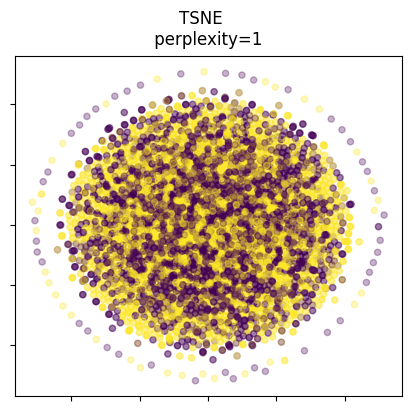

  6%|████▉                                                                              | 1/17 [00:24<06:35, 24.72s/it]

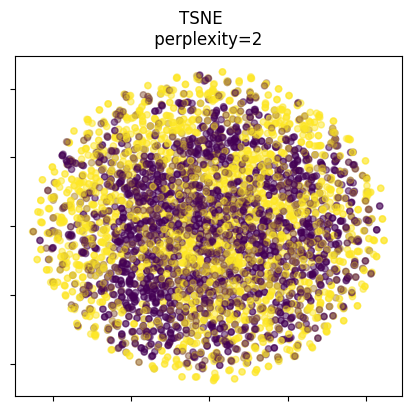

 12%|█████████▊                                                                         | 2/17 [00:49<06:08, 24.57s/it]

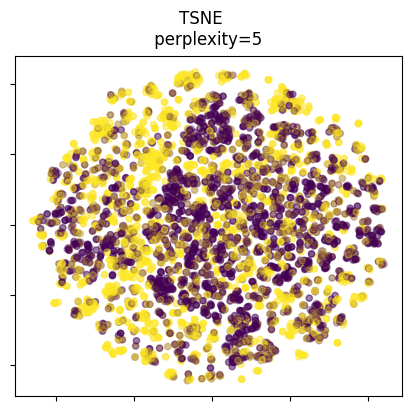

 18%|██████████████▋                                                                    | 3/17 [01:13<05:40, 24.33s/it]

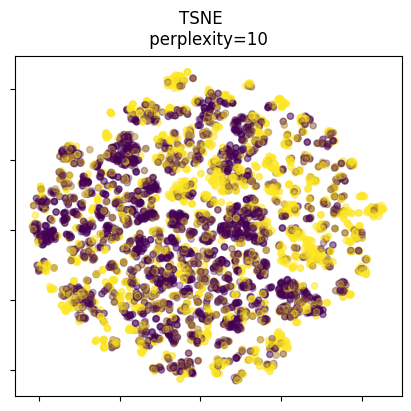

 24%|███████████████████▌                                                               | 4/17 [01:39<05:24, 24.94s/it]

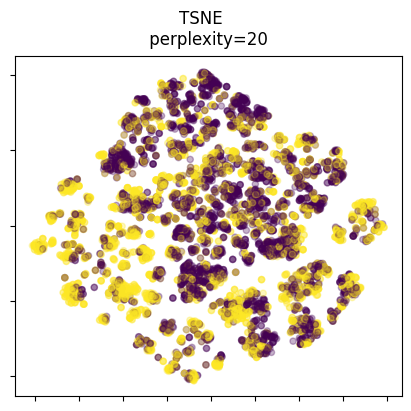

 29%|████████████████████████▍                                                          | 5/17 [02:07<05:16, 26.34s/it]

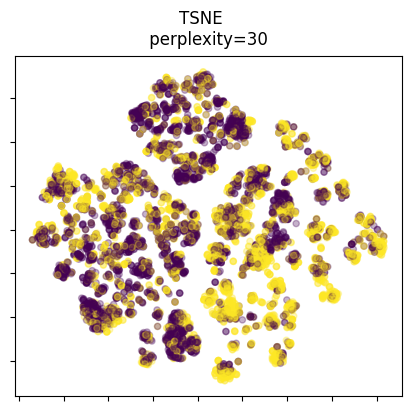

 35%|█████████████████████████████▎                                                     | 6/17 [02:40<05:12, 28.43s/it]

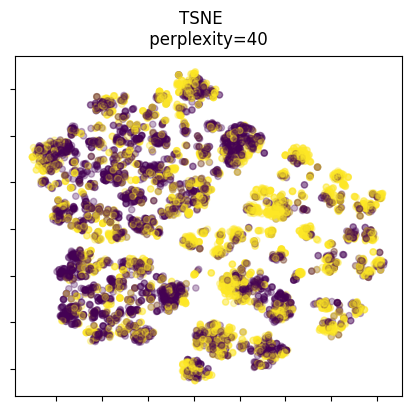

 41%|██████████████████████████████████▏                                                | 7/17 [03:16<05:08, 30.85s/it]

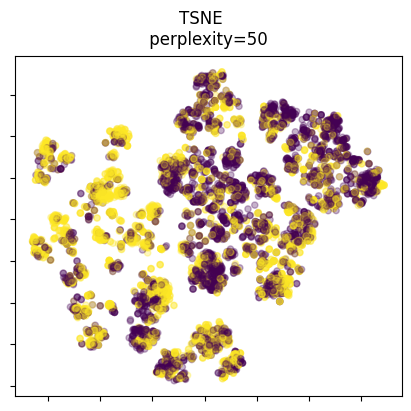

 47%|███████████████████████████████████████                                            | 8/17 [03:54<05:00, 33.34s/it]

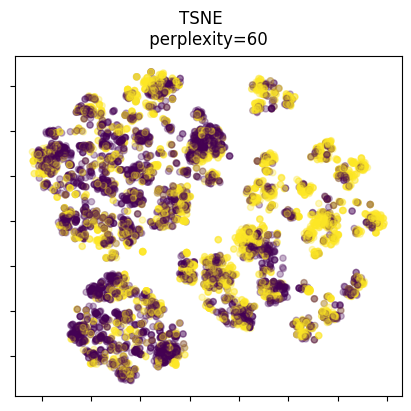

 53%|███████████████████████████████████████████▉                                       | 9/17 [04:36<04:47, 35.99s/it]

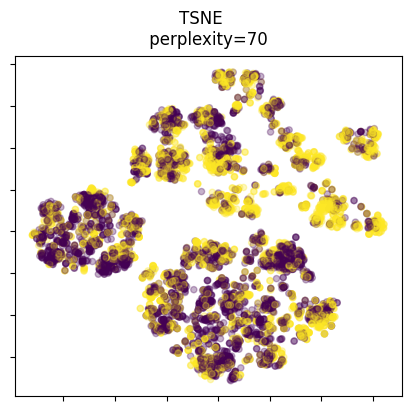

 59%|████████████████████████████████████████████████▏                                 | 10/17 [05:19<04:27, 38.17s/it]

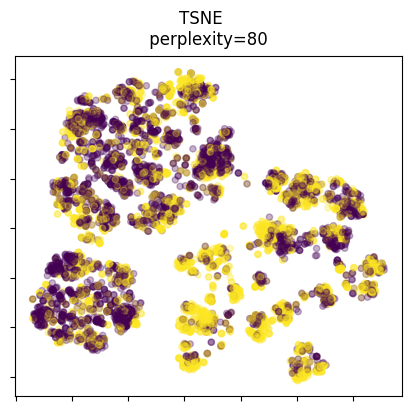

 65%|█████████████████████████████████████████████████████                             | 11/17 [06:05<04:02, 40.35s/it]

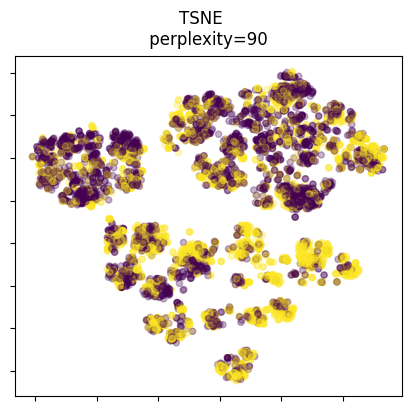

 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [06:55<03:37, 43.48s/it]

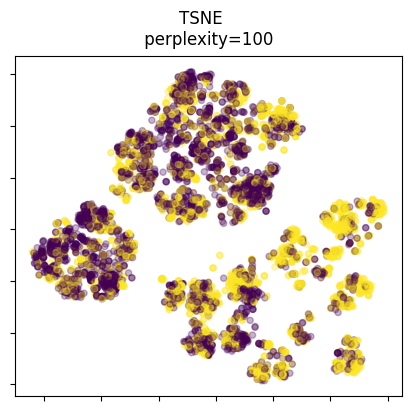

 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [07:46<03:03, 45.80s/it]

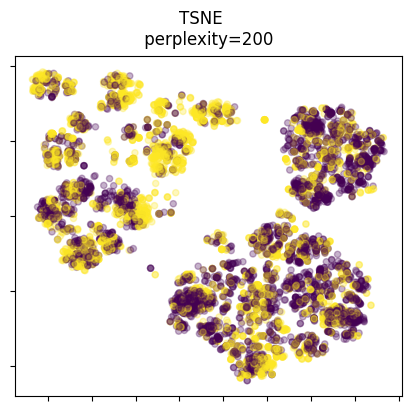

 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [09:08<02:49, 56.48s/it]

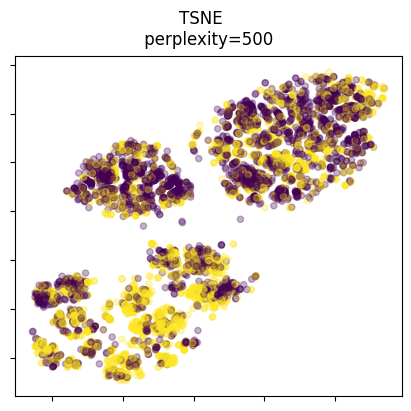

 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [11:49<02:56, 88.27s/it]

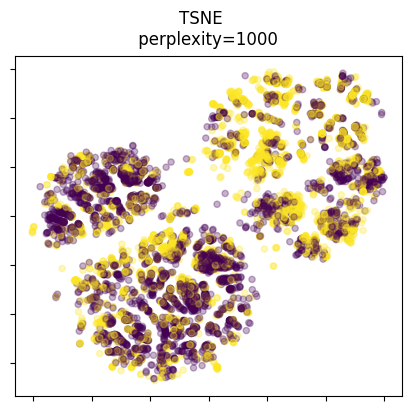

 94%|████████████████████████████████████████████████████████████████████████████▏    | 16/17 [16:20<02:23, 143.21s/it]

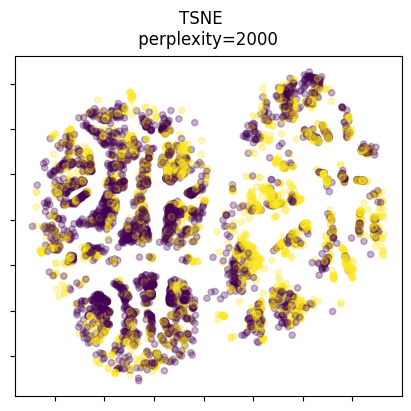

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [22:24<00:00, 79.06s/it]


In [16]:
from tqdm import tqdm
for perplexity in tqdm([1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]):
    t_sne = manifold.TSNE(n_components = n_components, perplexity = perplexity)

    points_tsne = t_sne.fit_transform(X_tsne)

    plot_2d(points_tsne, is_fraud_balanced, f"TSNE  \n perplexity={perplexity}")
    plt.show()

### Plot with best perplexity

In [20]:
def plot_scatter(points_tsne, is_fraud_balanced):
    fig, ax = plt.subplots(figsize=(12, 7), facecolor="white", constrained_layout=True)

    # draw not fraud transactions
    x, y = points_tsne[is_fraud_balanced==0].T
    ax.scatter(x, y, c='blue', s=20, alpha=0.3, label='Not Fraud')

    # draw not fraud transactions
    x_fraud, y_fraud = points_tsne[is_fraud_balanced==1].T
    ax.scatter(x_fraud, y_fraud, c='orange', s=20, alpha=0.3, label='Fraud')

    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.legend()
#     plt.show()

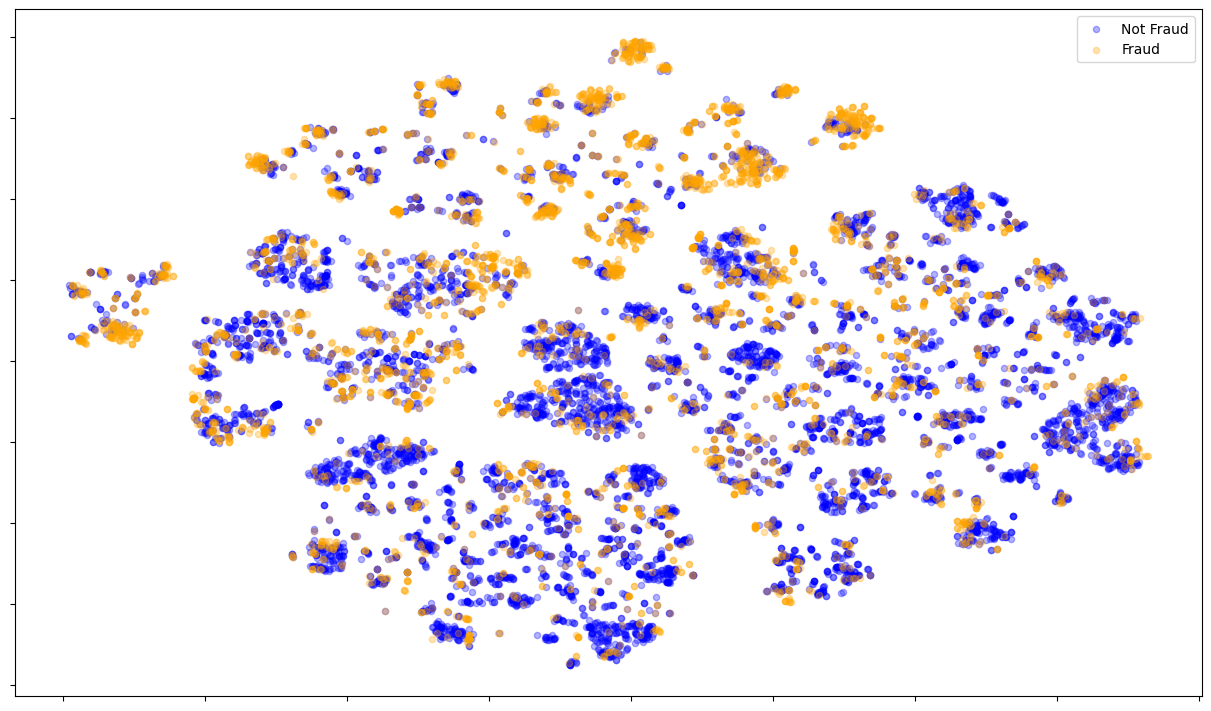

In [23]:
t_sne = manifold.TSNE(n_components = n_components, perplexity = 30)
points_tsne = t_sne.fit_transform(X_tsne)
plot_scatter(points_tsne, is_fraud_balanced)
# plt.savefig(f'tsne/final_perplexity_30.png')
plt.show()

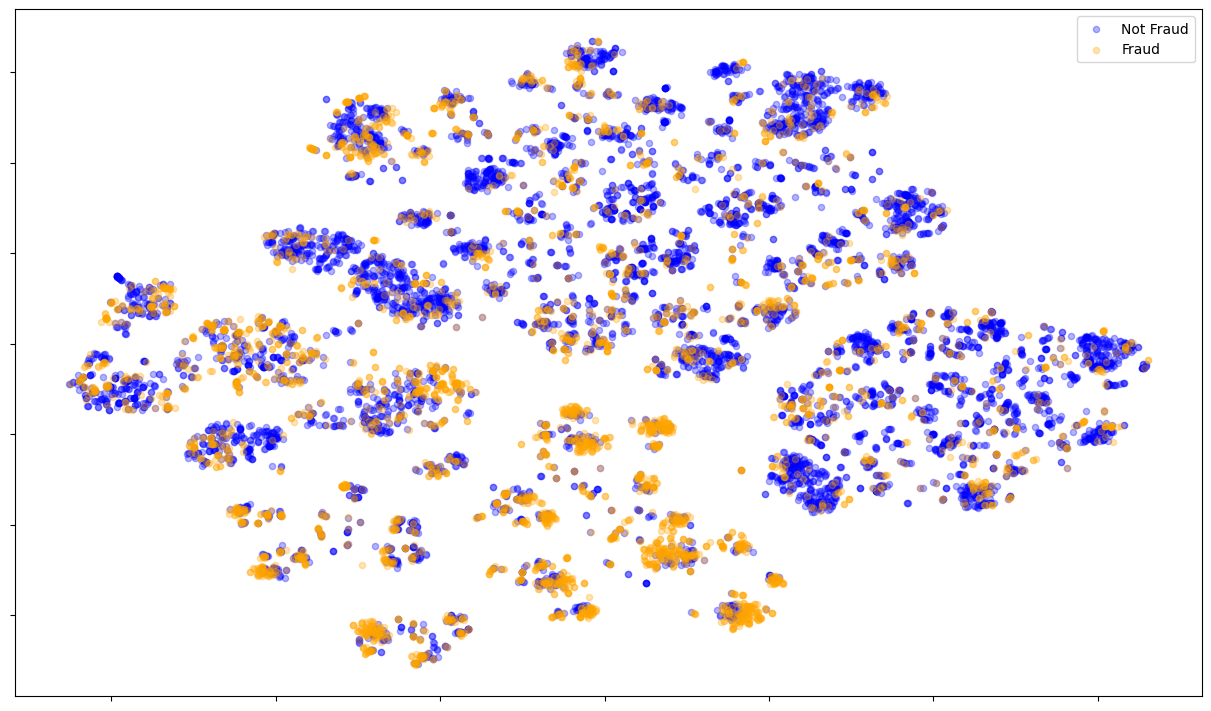

In [24]:
t_sne = manifold.TSNE(n_components = n_components, perplexity = 50)
points_tsne = t_sne.fit_transform(X_tsne)
plot_scatter(points_tsne, is_fraud_balanced)
# plt.savefig(f'tsne/final_perplexity_50.png')
plt.show()